In [6]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import PIL
import time
from IPython.display import clear_output
tf.enable_eager_execution()

In [7]:
path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz', 
                                      extract=True)

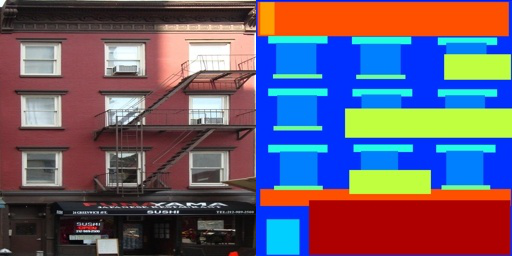

In [24]:
PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')
PIL.Image.open(PATH+'/test/'+img)

In [9]:
BUFFER_SIZE=4000
BATCH_SIZE=1
IMG_WIDTH=256
IMG_HEIGHT=256

In [10]:
tf.executing_eagerly()

True

In [22]:
def load_image(image_file,is_train):
    image = tf.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    w = tf.shape(image)[1]
    w = w // 2
    real_image = image[:,:w,:]
    input_image = image[:,w:,:]
    
    input_image = tf.cast(input_image,dtype=tf.float32)
    real_image = tf.cast(real_image,dtype=tf.float32)
    
    if is_train:
        input_image = tf.image.resize_images(input_image,size=[286,286], align_corners=True, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        real_image = tf.image.resize_images(real_image,size=[286,286],align_corners=True,method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        stacked_image = tf.stack([input_image,real_image], axis=0)
        cropped_image = tf.random_crop(stacked_image,size=[2,IMG_WIDTH,IMG_HEIGHT,3])
        input_image , real_image = cropped_image[0],cropped_image[1]
        input_image = tf.image.resize_images(input_image,size=[IMG_WIDTH,IMG_HEIGHT],align_corners=True,method=2)
        real_image = tf.image.resize_images(real_image,size=[IMG_WIDTH,IMG_HEIGHT],align_corners=True,method=2)
    input_image = (input_image/127.5) - 1
    real_image = (real_image/127.5) - 1
    return input_image,real_image

In [23]:
train_datasets = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_datasets = train_datasets.shuffle(BUFFER_SIZE)
train_datasets = train_datasets.map(lambda x: load_image(x,True))
train_datasets = train_datasets.batch(1)


In [25]:
test_datasets = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_datasets = test_datasets.map(lambda x: load_image(x,False))
test_datasets = test_datasets.batch(1)

In [26]:
OUTPUT_CHANNELS = 3

In [42]:
class DownSample(tf.keras.Model):
    def __init__(self,filters,size,apply_batch_norm=True):
        super(DownSample,self).__init__()
        self.apply_batchnorm = apply_batch_norm
        initializer = tf.random_normal_initializer(0.,0.02)
        self.conv2D = tf.keras.layers.Conv2D(filters=filters,kernel_size=(size,size),
                                             padding='same',kernel_initializer=initializer,
                                             strides=2,use_bias=False)
        if self.apply_batchnorm:
            self.batchnorm = tf.keras.layers.BatchNormalization()

    def call(self, x ,training):
        self.conv2D(x)
        if self.apply_batchnorm:
            x = self.batchnorm(x, training=training)
        x = tf.nn.leaky_relu(x)
        return x

In [59]:
class UpSample(tf.keras.Model):
    def __init__(self,filters,size,apply_dropout=False):
        super(UpSample,self).__init__()
        initializer = tf.random_normal_initializer(0.,0.02)
        self.apply_dropout = apply_dropout
        self.conv2dtranspose = tf.keras.layers.Conv2DTranspose(filters = filters,kernel_size=(size,size),padding='same',
                                                               kernel_initializer=initializer,use_bias=False,strides=2)
        self.batchnorm = tf.keras.layers.BatchNormalization()
        if self.apply_dropout:
            self.dropout = tf.keras.layers.Dropout(rate=0.5)
    
    def call(self,x1,x2,training):
        x = self.conv2dtranspose(x1)
        if self.apply_dropout:
            x = self.dropout(x,training=training)
        x = tf.nn.relu(x)
        x = tf.concat([x,x2],axis=-1)
        return x
            
                        

In [64]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        initializer = tf.random_normal_initializer(0.,0.02)
        self.down1 =  DownSample(64,4)
        self.down2 = DownSample(128,4)
        self.down3 = DownSample(256,4)
        self.down4 = DownSample(512,4)
        self.down5 = DownSample(512,4)
        self.down6 = DownSample(512,4)
        self.down7 = DownSample(512,4)
        self.down8 = DownSample(512,4)
        self.up1 = UpSample(512,4,apply_dropout=True)
        self.up2 = UpSample(512,4,apply_dropout=True)
        self.up3 = UpSample(512,4,apply_dropout=True)
        self.up4 = UpSample(512, 4)
        self.up5 = UpSample(256, 4)
        self.up6 = UpSample(128, 4)
        self.up7 = UpSample(64, 4)
        self.last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,(4,4),strides=2,
                                                    padding='same',kernel_initializer=initializer)
    
    @tf.contrib.eager.defun
    def call(self,x,training):
        x1 = self.down1(x,training=training)
        x2 = self.down2(x,training=training)
        x3 = self.down3(x,training=training)
        x4 = self.down4(x,training=training)
        x5 = self.down5(x,training=training)
        x6 = self.down6(x5, training=training) 
        x7 = self.down7(x6, training=training) 
        x8 = self.down8(x7, training=training) 
        
        x9 = self.up1(x8,x7, training=training)
        x10 = self.up2(x9,x6,training=training)
        x11 = self.up3(x10,x5,training=training)
        x12 = self.up4(x11,x4,training=training)
        x13 = self.up5(x12,x3,training=training)
        x14 = self.up6(x13,x2,training=training)
        x15 = self.up7(x14,x1,training=training)
        x16 = self.last(x15)
        res = tf.nn.tanh(x16)
        return res

In [65]:
class DiscDownSample(tf.keras.Model):
    def __init__(self,filters,size,apply_norm=True):
        super(DiscDownSample,self).__init__()
        initializer = tf.random_normal_initializer(0.,0.02)
        self.apply_norm = apply_norm
        self.conv2d = tf.keras.layers.Conv2D(filter,(size,size),padding='same',strides=2,kernel_initializer=initializer,
                                             use_bias=False)
        if self.apply_norm:
            self.norm = tf.layers.BatchNormalization()
        
    def call(self,x,training):
        convd = self.conv2d(x)
        if self.apply_norm:
            convd = self.norm(convd,training=training)
        convd = tf.nn.leaky_relu(convd)
        return convd

In [72]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator,self).__init__()
        initializer = tf.random_normal_initializer(0.,0.02)
        self.down1 = DiscDownSample(64,4,False)
        self.down2 = DiscDownSample(128,4)
        self.down3 = DiscDownSample(256,4)
        self.zero_pad = tf.keras.layers.ZeroPadding2D()
        self.conv = tf.keras.layers.Conv2D(512,(4,4),strides=1,padding='same',
                                           use_bias=False,kernel_initializer=initializer)
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.zero_pad2 = tf.keras.layers.ZeroPadding2D()
        self.conv2 = tf.keras.layers.Conv2D(1,(4,4),strides=1,padding='same',kernel_initializer=initializer,use_bias=False)
        
    @tf.contrib.eager.defun   
    def call(self,inp,tar,training):
        x = tf.concat([inp,tar],axis=-1)
        x = self.down1(x,training=training)
        x = self.down2(x,training=training)
        x = self.down3(x, training=training)
        x = self.zero_pad(x, training=training)
        x = self.conv(x)
        x = self.batchnorm(x,training=training)
        x = tf.nn.leaky_relu(x)
        x = self.zero_pad2(x,training=training)
        x = self.conv2(x)
        return x 

In [73]:
generator = Generator()
discriminator = Discriminator()

In [74]:
def discriminator_loss(disc_real_output,disc_generated_output):
    real_disc_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(disc_real_output),
                                                     logits=disc_real_output)
    output_disc_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(disc_generated_output),
                                                      logits=disc_generated_output)
    total_loss = real_disc_loss + output_disc_loss
    return total_loss

In [75]:
def generator_loss(disc_generated_output,generated_output,target):
    gen_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(disc_generated_output),logits=disc_generated_output)
    l1loss = tf.reduce_mean(tf.abs(target-generated_output))
    total_loss = gen_loss+100*l1loss
    return total_loss

In [ ]:
generator_optimizer = tf.train.AdamOptimizer(0.002)
discrminator_optimizer = tf.train.AdamOptimizer(0.002)